In [ ]:
!pip install japanize_matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 52.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize_matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=76534b0f087717e2c0302f3aa3ff9502c0377bb152b7613481ea98c3a6e37ed6
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize_matplotlib


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np

class FCNNet(nn.Module):
    def __init__(self, num_classes=18):  # 必要なクラス数を指定
        super(FCNNet, self).__init__()
        self.num_classes = num_classes  # num_classesをクラスの属性として保存
        self.conv1 = nn.Conv2d(3, 6, 5)  # 畳み込み層
        self.pool = nn.MaxPool2d(2, 2)  # プーリング層
        self.conv2 = nn.Conv2d(6, 16, 5)  # 畳み込み層
        self.conv3 = nn.Conv2d(16, 256, 1)  # 1x1畳み込み層でチャンネル数を増やす
        self.conv4 = nn.Conv2d(256, num_classes, 1)  # 1x1畳み込み層でクラス数に対応

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # プーリングと活性化
        x = self.pool(F.relu(self.conv2(x)))  # プーリングと活性化
        x = F.relu(self.conv3(x))  # 1x1畳み込みでチャンネル数を256に
        x = self.conv4(x)  # クラス数に変換
        x = F.adaptive_avg_pool2d(x, (1, 1))  # 全結合の代わりにGlobal Average Pooling
        x = x.view(-1, self.num_classes)  # クラス数に対応して出力を平坦化
        return x

# # デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# モデルのインスタンスを作成
loaded_net = FCNNet(num_classes=18).to(device)

# 学習済みパラメータをロード
loaded_net.load_state_dict(torch.load('/content/drive/MyDrive/PythonProjects/トレンド予測/model.pth'))

# モデルを評価モードに切り替え
loaded_net.eval()


FCNNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(16, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv4): Conv2d(256, 18, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import os

# テストデータのディレクトリパス
test_dir = '/content/drive/MyDrive/PythonProjects/トレンド予測/服の検出/img_test'

# 画像データの前処理を定義
transform = transforms.Compose([
    transforms.ToTensor(),        # テンソルに変換
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 正規化
])

# テストデータの読み込み
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.img_names = os.listdir(img_dir)

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, img_name

test_dataset = CustomDataset(test_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


In [ ]:
# モデルのインスタンスを作成し、学習済みパラメータをロード
loaded_net = FCNNet(num_classes=18).to(device)
loaded_net.load_state_dict(torch.load('/content/drive/MyDrive/PythonProjects/トレンド予測/model.pth'))
loaded_net.eval()

# 予測を行う
predictions = []

# 系統名のリスト（修正済み）
style_names = [
    'ベーシック',
    'アメリカンカジュアル（アメカジ）',
    'モードカジュアル',
    'スポーツカジュアル',
    'ストリートカジュアル',
    'アウトドア',
    'エレガンス',
    'ガーリー',
    'オフィスカジュアル',
    'キャリア',
    'マニッシュ',
    'デザイナーズ',
    'トラッド',
    'ノームコア',
    'ナチュラル',
    '韓国（オルチャン）',
    '量産型',
    '地雷系'
]

with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = loaded_net(images)
        _, predicted = torch.max(outputs.data, 1)

        # 予測されたクラス番号をスタイル名に変換
        predicted_class = predicted.item()
        predicted_style = style_names[predicted_class]

        predictions.append((img_names[0], predicted_style))

# 結果を表示
for img_name, style in predictions:
    print(f"Image: {img_name} - Predicted Style: {style}")


Image: 625.jpg - Predicted Style: ベーシック
Image: 647.jpg - Predicted Style: トラッド
Image: 652.jpg - Predicted Style: 地雷系
Image: 1.jpg - Predicted Style: 地雷系
Image: 2.jpg - Predicted Style: 地雷系
Image: 4.jpg - Predicted Style: スポーツカジュアル
Image: images.jpg - Predicted Style: ベーシック


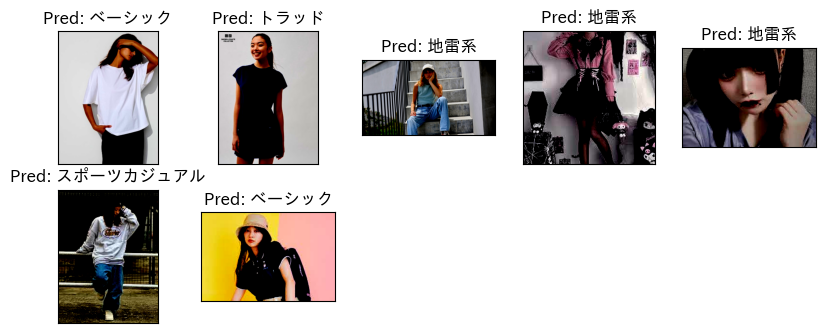

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

# モデルのインスタンスを作成し、学習済みパラメータをロード
loaded_net = FCNNet(num_classes=18).to(device)
loaded_net.load_state_dict(torch.load('/content/drive/MyDrive/PythonProjects/トレンド予測/model.pth'))
loaded_net.eval()

# 予測と可視化を行う
images_list = []
predicted_list = []

with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)
        outputs = loaded_net(images)
        _, predicted = torch.max(outputs.data, 1)

        # 画像と予測結果をリストに保存
        images_list.append(images.cpu())
        predicted_list.append(predicted.cpu())

# 可視化
n_image = len(images_list)
plt.figure(figsize=(10, 10))

for i in range(n_image):
    plt.subplot(5, 5, i+1)
    # 画像をテンソルからNumpy配列に変換して表示
    plt.imshow(np.transpose(images_list[i].squeeze(0).numpy(), (1, 2, 0)))
    plt.title(f"Pred: {style_names[predicted_list[i].item()]}")
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

plt.show()
